
## Importing Necessary Qiskit and Pytorch Packages
Blog where quantum implementation came from: https://blog.usejournal.com/quantum-machine-learning-hybrid-quantum-classical-machine-learning-with-pytorch-and-qiskit-d03da758d58b

In [1]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from matplotlib import pyplot as plt
from time import time
import math
from torch.autograd import Variable
%matplotlib inline

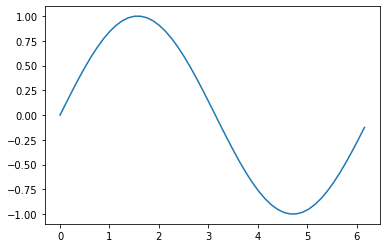

In [2]:
data_points = 50
x = np.array([p for p in np.arange(0, 2*math.pi, (2*math.pi / data_points))])
y = np.array([math.sin(a) for a in x])
plt.plot(x,y);

x = torch.Tensor(x).unsqueeze(1).double()
y = torch.Tensor(y).unsqueeze(1).double()

train_x, train_labels = Variable(x), Variable(y)
# trainer = list(zip(sin_x_T,sin_y_T))

## - Tensor to List

In [3]:
def to_numbers(tensor_list):
    list = []
    for tensor in tensor_list:
        list += [tensor.item()]
    return list

## **QISKIT CIRCUIT**

In [4]:
class QiskitCircuit():
    
    # Specify initial parameters and the quantum circuit
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.ry(self.theta,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self, counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

# Torch Circuit

In [5]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100000)
        exp_value = ctx.QiskitCirc.run(i[0])
#         exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value]) # store the result as a torch tensor
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        s = np.pi/2
        
        forward_tensor, i = ctx.saved_tensors  
        
        # Obtain paramaters 
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_plus_s = input_numbers
            input_plus_s[k] = input_numbers[k] + s  # Shift up by s
            
            exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_plus_s))[0]
            result_plus_s = torch.tensor([exp_value_plus])
            
            input_minus_s = input_numbers
            input_minus_s[k] = input_numbers[k] - s # Shift down by s
            
            exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_minus_s))[0]
            result_minus_s = torch.tensor([exp_value_minus])

            gradient_result = (result_plus_s - result_minus_s)

            gradient.append(gradient_result)
            
        result = torch.tensor([gradient])
        
        return result.float() * grad_output.float()

In [6]:
data_points = 50
x_raw = np.array([p for p in np.arange(0, 2*math.pi, (2*math.pi / data_points))])
y_raw = np.array([math.sin(a) for a in x_raw])

x = torch.Tensor(x_raw).unsqueeze(1)#.unsqueeze(1)
y = torch.Tensor(y_raw).unsqueeze(1).double()

x, y = Variable(x,requires_grad=True), Variable(y,requires_grad=True)


trainset = list(zip(x,y))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

In [7]:
qc = TorchCircuit.apply 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.linear1 = nn.Linear(1,64)
        self.linear2 = nn.Linear(64,64)
        self.linear3 = nn.Linear(64,64)
        self.linear4 = nn.Linear(64,1)
        
    def forward(self, x):
        
        x = torch.tanh(self.linear1(x))
        x = torch.tanh(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        x = self.linear4(x)
        x = qc(x)
        
        return x

network = Net()
# optimizer = optim.Adam(network.parameters(), lr=0.001, amsgrad=True)
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9, nesterov=True)
criterion = nn.MSELoss()
epochs = 20
time0 = time()
losses_list = []

for epoch in range(epochs):
    loss_list = []
#     shuffle each epoch
    shuf_inds = torch.randperm(x.shape[0])
    x = x[shuf_inds]
    y = y[shuf_inds]
    
    for batch_idx, (data,target) in enumerate(trainloader):
        output = network(data).double()
        loss = criterion(output, target)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 0 or (epoch+1) % 1 == 0:
        epoch_loss = sum(loss_list) / len(loss_list)
        losses_list.append(epoch_loss)
        print(f"e:{epoch+1} loss:{sum(loss_list) / len(loss_list)}")

e:1 loss:0.36401625062130916
e:2 loss:0.22204301759704964
e:3 loss:0.13736132553617322
e:4 loss:0.07499451588397012
e:5 loss:0.05832580568876703
e:6 loss:0.05622166127175085
e:7 loss:0.06144906366284391
e:8 loss:0.06037669758877263
e:9 loss:0.06886524761390979
e:10 loss:0.062226876061190935
e:11 loss:0.06249123909212972
e:12 loss:0.14377292991672666
e:13 loss:0.059350997120916474
e:14 loss:0.05429902349762603
e:15 loss:0.06538570713736208
e:16 loss:0.061354660117875964
e:17 loss:0.053908160887710804
e:18 loss:0.06915925496119707
e:19 loss:0.047994256576854195
e:20 loss:0.06686307643036207


We can see that the quantum implementation is not precise enough to minimize the loss beyond a certain number due to that fact that it is a simulation with shots. We can increase the number of shots to reduce the variance but it dramatically decreases training time and still cannot be precise enough to fit the sin curve with a loss less than 0.05. 

The model performs much better without the quantum layer.

In [8]:
qc = TorchCircuit.apply 
l = []
for i in range(50):
    l.append(qc(torch.Tensor([0]).unsqueeze(1)).item())

max(l) - min(l)

0.014739999999999975

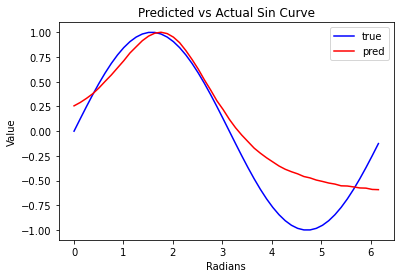

In [9]:
data_points = 50
x = np.array([p for p in np.arange(0, 2*math.pi, (2*math.pi / data_points))])

x = torch.Tensor(x).unsqueeze(1)

preds = []
for i in x:
    preds.append(network(i.unsqueeze(1)).detach().item())

# preds = []
# for i in x:
#     preds.append(network(i.unsqueeze(1)).detach().numpy()[0][0])
plt.plot(x_raw, y_raw, c='blue', label='true')
plt.plot(x_raw, preds, c='red', label='pred')
plt.title('Predicted vs Actual Sin Curve')
plt.ylabel('Value')
plt.xlabel('Radians')
plt.legend();

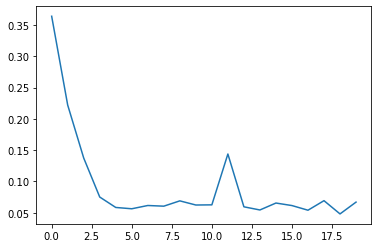

In [10]:
plt.plot(losses_list)